In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

[  0   1   2   3   4   5   6 100 101 102 103]
Sample rate: 387.91730982321576 Hz
Orientation: 107.8569304116857 deg
Index(['Motor Torque [Nm]', 'Deflection [deg]', 'Desired Torque [Nm]',
       'Q_current/5', 'test_nr'],
      dtype='object')


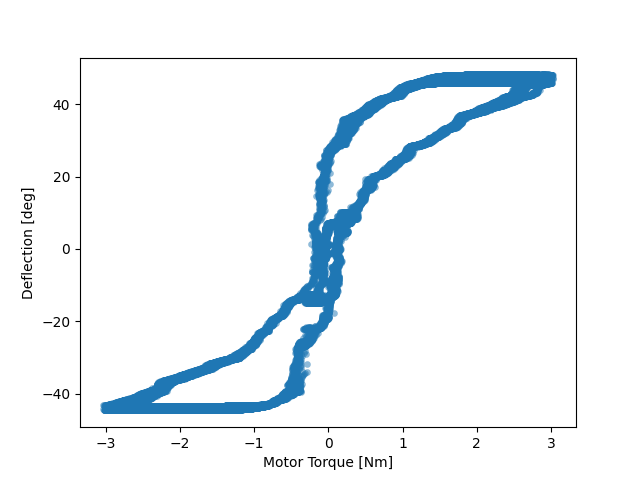

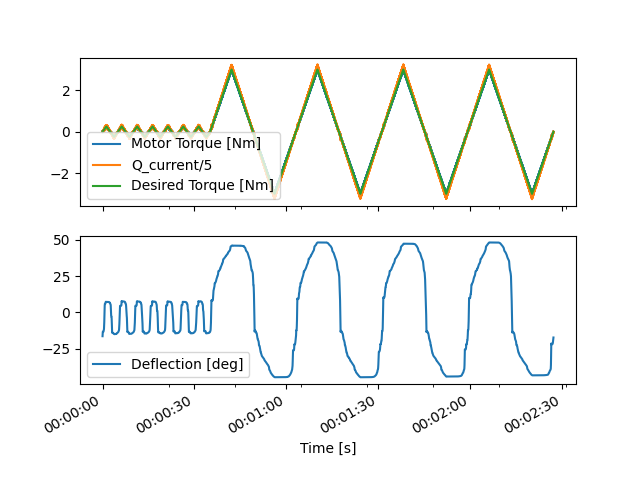

In [2]:
# filename = 'test_data/2024-06-19__17-11-31__torqueramp__Baseline with output play.csv'     # added intentional play at output (adds a few degrees)
# filename = 'test_data/2024-06-20__12-54-45__torqueramp__Baseline.csv'          # fixed output, many repetitions play= 5mm at 27.5cm = 1.05 degrees 

filename = 'test_data/2024-06-20__16-12-43__torqueramp__Baseline Run-in Reassmeble.csv'    #run-in baseline after reassembly. Calibrated for 20Hz


df_raw = pd.read_csv(filename)
# print(df_raw.head())
print(df_raw['test_nr'].unique())

df = pd.DataFrame()
df['Time [s]'] = df_raw['TIME']
df['Motor Torque [Nm]'] = df_raw['TORQUE']  #.rolling(window=20, center=True).mean()
df['Deflection [deg]'] = df_raw['POSITION'] * 360
df['Desired Torque [Nm]'] = df_raw['CONTROL_TORQUE']
df['Q_current/5'] = df_raw['Q_CURRENT']/5
df['test_nr'] = df_raw['test_nr']

sample_rate = 1/(df['Time [s]'].diff().mean())
# to datetime
df['Time [s]'] = pd.to_datetime(df['Time [s]'], unit='s')
df.set_index('Time [s]', inplace=True)

orientation = df['Deflection [deg]'].mean()
df['Deflection [deg]'] -= orientation

print(f'Sample rate: {sample_rate} Hz')
print(f'Orientation: {orientation} deg')
print(df.columns)
# print(df.head())

fig, axs = plt.subplots(2, 1, sharex=True)
df.plot(y=['Motor Torque [Nm]', 'Q_current/5', 'Desired Torque [Nm]'], ax=axs[0])
df.plot(y='Deflection [deg]', ax=axs[1])

hyst_ax = df.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='scatter', linewidth=0.2, alpha=0.5)
# df.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=hyst_ax)
plt.show()

## averaging
Test contains multiple repetition of back and forth torque ramps. An average hysteris curve is calculated for the combined tests

test 0 resampled from 1945 to 10024 samples
test 1 resampled from 1861 to 10029 samples
test 2 resampled from 1926 to 10020 samples
test 3 resampled from 1934 to 10011 samples
test 4 resampled from 1944 to 10017 samples
test 5 resampled from 1948 to 10009 samples
test 6 resampled from 1945 to 10011 samples
setting everything to 10009 samples
test 0 resampled from 10877 to 56027 samples
test 1 resampled from 11018 to 56031 samples
test 2 resampled from 10859 to 56028 samples
test 3 resampled from 10864 to 56029 samples
setting everything to 56027 samples


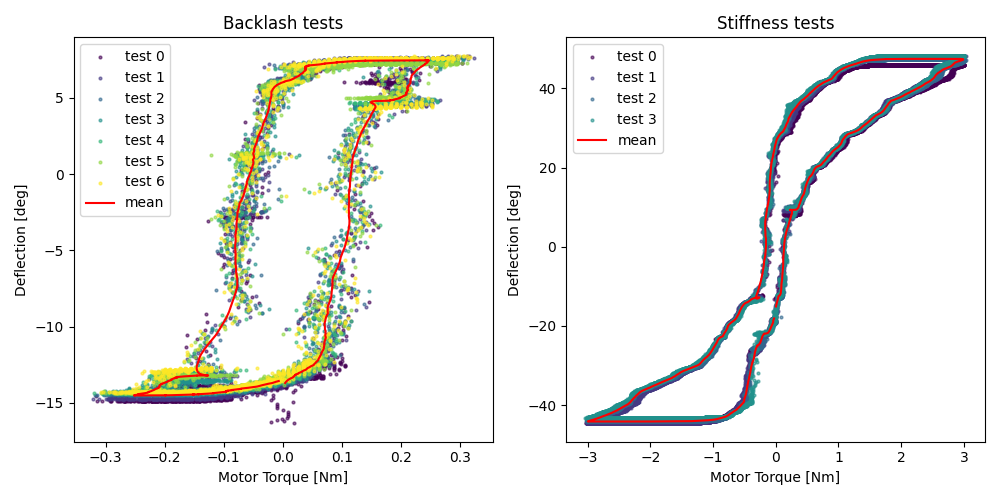

In [3]:
def average_data(df):
    data = []
    grouped = df.groupby('test_nr')

    for name, group in grouped:
        group = group.drop('test_nr', axis=1)
        group.index = group.index - group.index[0]

        old_len = len(group)
        group = group.resample('0.5ms').mean()
        group = group.interpolate(method='time')
        print(f'test {name} resampled from {old_len} to {len(group)} samples')

        data.append(group.values)

    # get consistent length
    min_len = min([len(d) for d in data])
    data = [d[:min_len] for d in data]
    print(f'setting everything to {min_len} samples')

    # average data using numpy
    data_mean = np.mean(np.array(data), axis=0)

    new_columns = df.columns.drop('test_nr')
    mean_df = pd.DataFrame(data_mean, columns=new_columns)

    # smooth data
    mean_df = mean_df.rolling(window=100, center=True).mean()
    mean_df = mean_df.bfill().ffill()

    return mean_df


TEST_NR_OFFSET = 100
play_tests = df[df['test_nr'] < TEST_NR_OFFSET].copy()
stiffness_tests = df[df['test_nr'] >= TEST_NR_OFFSET].copy()
stiffness_tests['test_nr'] = stiffness_tests['test_nr'] - TEST_NR_OFFSET

play_test_mean = average_data(play_tests)
stiffness_test_mean = average_data(stiffness_tests)


# plot torque ramp curves for each test, then overlay mean
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# colors = plt.cm.cividis(np.linspace(0, 1, play_tests['test_nr'].max() + 2))
colors = plt.cm.viridis(np.linspace(0, 1, play_tests['test_nr'].max() + 1))

for i in range(play_tests['test_nr'].max() + 1):
    test = play_tests[play_tests['test_nr'] == i]
    color = np.array([colors[i]])
    test.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='scatter', ax=axs[0], alpha=0.6, label=f'test {i}', color=color, s=4)
color = np.array([colors[-1]])
play_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='mean', color='red') 
axs[0].set_title('Backlash tests')

for i in range(stiffness_tests['test_nr'].max() + 1):
    test = stiffness_tests[stiffness_tests['test_nr'] == i]
    color = np.array([colors[i]]) 
    test.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='scatter', ax=axs[1], alpha=0.6, label=f'test {i}', color=color, s=4)
color = np.array([colors[-1]]) 
stiffness_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='mean', color='red')
axs[1].set_title('Stiffness tests')

# save plot
fig.tight_layout()
fig.savefig(f'{filename}.png')
plt.show()

# Estimating play and stiffness

Play is estimated from the displacement difference when the torque reverses direction.

Stiffnes is calculated on the behaviour during a rising torque, ignoring the part affected by play.

Play: 19.755218287876673 deg (-13.703997410848642 pos, 6.051220877028032 neg)
Positive stiffness: 13.25814369927632 deg/Nm, offset: 10.381617678668428 deg
Negative stiffness: 11.159778849955448 deg/Nm, offset: -13.18632687284372 deg


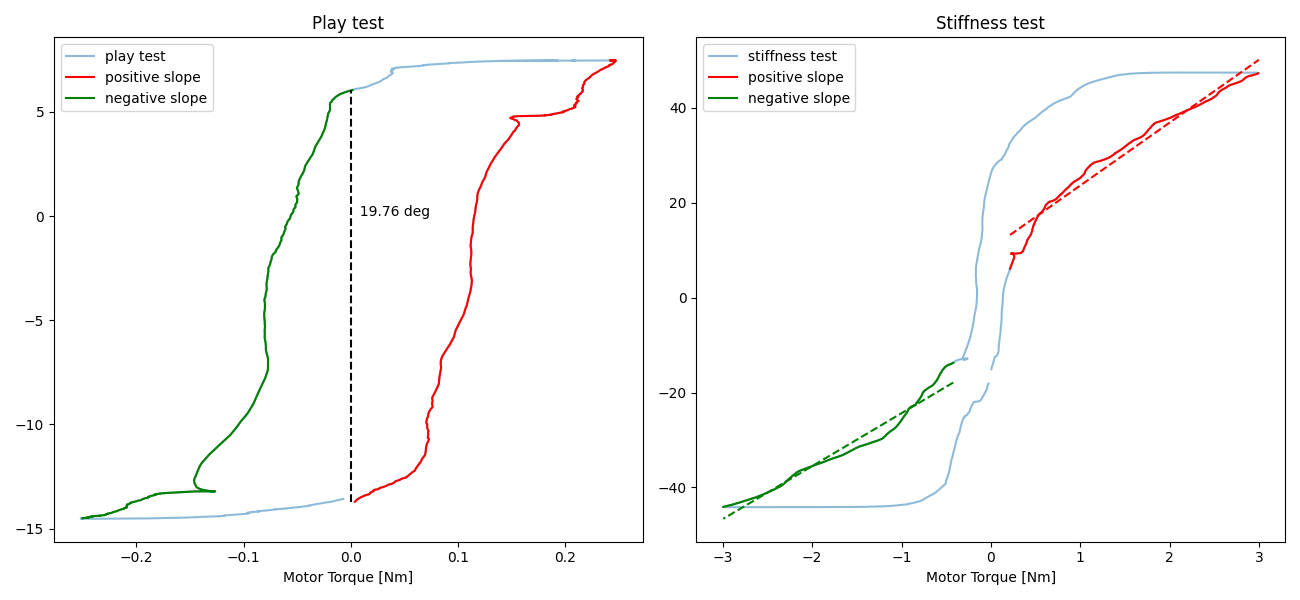

In [4]:
def get_rising_slopes(df):
    # split data in to positive and negative slopes. remove the hysteresis part
    max_torque_idx = df['Desired Torque [Nm]'].idxmax()
    pos_slope = df.loc[:max_torque_idx]

    # find zero crossing of desired torque
    min_torque_idx = df['Desired Torque [Nm]'].idxmin()
    zero_torque_idx = df['Desired Torque [Nm]'][max_torque_idx:min_torque_idx].abs().idxmin()
    neg_slope = df.loc[zero_torque_idx:min_torque_idx]

    return pos_slope, neg_slope


# estimate play
play_pos_slope, play_neg_slope = get_rising_slopes(play_test_mean)
pos_play = play_pos_slope['Deflection [deg]'].iloc[0]
neg_play = play_neg_slope['Deflection [deg]'].iloc[0]
print(f'Play: {neg_play-pos_play} deg ({pos_play} pos, {neg_play} neg)')


# estimate stiffness
stiffness_pos_slope, stiffness_neg_slope = get_rising_slopes(stiffness_test_mean)
stiffness_pos_slope = stiffness_pos_slope[stiffness_pos_slope['Deflection [deg]'] > neg_play]
stiffness_neg_slope = stiffness_neg_slope[stiffness_neg_slope['Deflection [deg]'] < pos_play]

# do polyfit
pos_stifness, pos_offset = np.polyfit(stiffness_pos_slope['Motor Torque [Nm]'], stiffness_pos_slope['Deflection [deg]'], 1)
neg_stifness, neg_offset  = np.polyfit(stiffness_neg_slope['Motor Torque [Nm]'], stiffness_neg_slope['Deflection [deg]'], 1)

print(f'Positive stiffness: {pos_stifness} deg/Nm, offset: {pos_offset} deg')
print(f'Negative stiffness: {neg_stifness} deg/Nm, offset: {neg_offset} deg')


fig, axs = plt.subplots(1, 2, figsize=(13, 6))
play_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='play test', alpha=0.5)
play_pos_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='positive slope', color='r')
play_neg_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='negative slope', color='g')
# add line to show play
axs[0].plot([0, 0], [pos_play, neg_play], color='black', linestyle='--')
axs[0].text(0, 0, f'  {neg_play-pos_play:.2f} deg', color='black')
axs[0].set_title('Play test')

stiffness_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='stiffness test', alpha=0.5)
stiffness_pos_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='positive slope', color='r')
stiffness_neg_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='negative slope', color='g')
axs[1].plot(stiffness_pos_slope['Motor Torque [Nm]'], pos_offset + pos_stifness*stiffness_pos_slope['Motor Torque [Nm]'], color='r', linestyle='--')
axs[1].plot(stiffness_neg_slope['Motor Torque [Nm]'], neg_offset + neg_stifness*stiffness_neg_slope['Motor Torque [Nm]'], color='g', linestyle='--')
axs[1].set_title('Stiffness test')

fig.tight_layout()
# fig.savefig(f'{filename}_results.png')
plt.show()



## Try out stuff

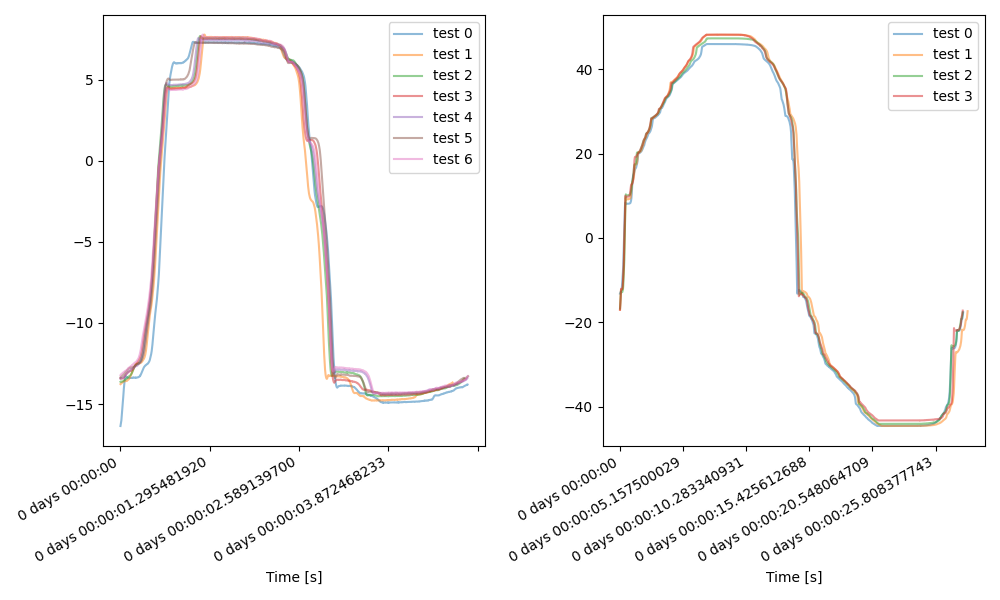

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
for test_nr, test in play_tests.groupby('test_nr'):
    test.index = test.index - test.index[0]
    test.plot(y='Deflection [deg]', kind='line', ax=axs[0], alpha=0.5, label=f'test {test_nr}')

for test_nr, test in stiffness_tests.groupby('test_nr'):
    test.index = test.index - test.index[0]
    test.plot(y='Deflection [deg]', kind='line', ax=axs[1], alpha=0.5, label=f'test {test_nr}')

fig.tight_layout()
plt.show()

Positive play deflections: [-2.7617155679356955, -0.3996550210606955, -13.182247794498196, 1.2318147055018045, 1.3251984945643045, 1.3471711508143045, 1.2647736898768045]
Negative play deflections: [2.2645295492518045, 2.2645295492518045, 1.8964875570643045, 2.2700227133143045, 3.0610383383143045, 4.4178498617518045]
Play amount: 11.580434945913462, std: 5.631996975547109, [8.800048828125, 16.0345458984375, 6.5753173828125, 15.8917236328125, 19.368896484375, 15.31494140625, 4.7406005859375, 15.7049560546875, 4.658203125, 16.41357421875, 4.6746826171875, 17.64404296875, 4.72412109375]


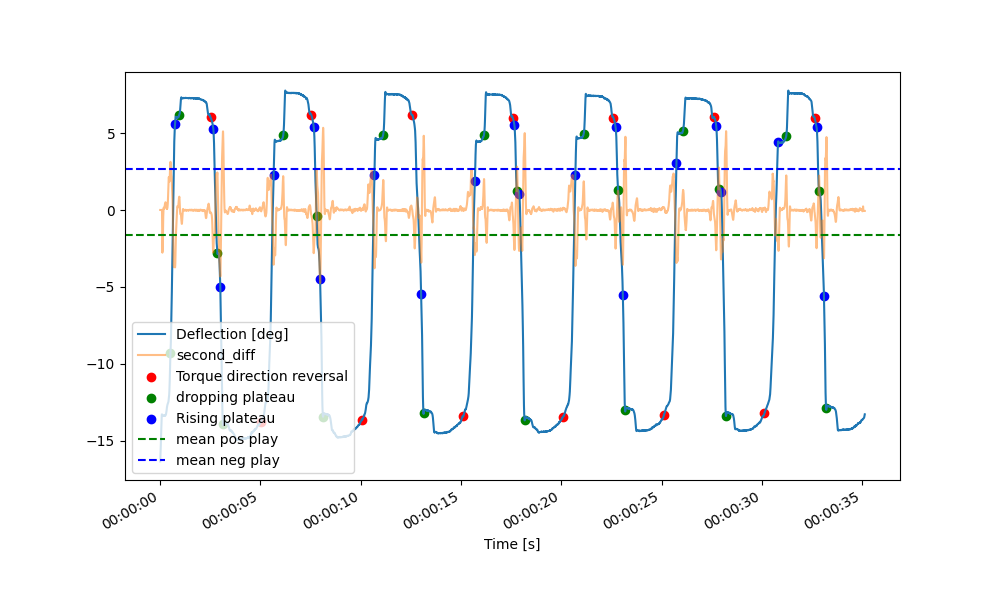

In [6]:
from scipy.signal import find_peaks

zero_crossings = np.where(np.diff(np.sign(play_tests['Desired Torque [Nm]'])))[0]

#zero_crossings are detected double or tripple, remove the ones too close together
zero_crossings_mask = zero_crossings[1:] - zero_crossings[:-1] > 10
zero_crossings = zero_crossings[1:][zero_crossings_mask]

# print(f'Zero crossings times: {play_tests.index[zero_crossings]}')

#peaks in second diff will indicate the change in slope. going from free play to stiffening. May also be stiction...
play_tests['Deflection smooth'] = play_tests['Deflection [deg]'].rolling(window=15, center=True).mean().bfill().ffill()
play_tests['second_diff'] = np.gradient(np.gradient(play_tests['Deflection smooth'])) * 1000
play_tests['second_diff'] = play_tests['second_diff'].rolling(window=50, center=True).mean().bfill().ffill()
peaks, _ = find_peaks(play_tests['second_diff'], prominence=3.5)
neg_peaks, _ = find_peaks(-play_tests['second_diff'], prominence=3.5)

# find the deflection at the first peak after a zero crossing
pplay_deflections = []
nplay_deflections = []
play_amount = []

for zc in zero_crossings:
    direction = np.sign(play_tests['Desired Torque [Nm]'].iloc[zc+50])
    if direction < 0:
        peak = peaks[peaks > zc][0]
        pplay_deflections.append(play_tests['Deflection [deg]'].iloc[peak])
        play_amount.append(-play_tests['Deflection [deg]'].iloc[peak] + play_tests['Deflection [deg]'].iloc[zc])
    else:
        peak = neg_peaks[neg_peaks > zc][0]
        nplay_deflections.append(play_tests['Deflection [deg]'].iloc[peak])
        play_amount.append(play_tests['Deflection [deg]'].iloc[peak] - play_tests['Deflection [deg]'].iloc[zc])

print(f'Positive play deflections: {pplay_deflections}')
print(f'Negative play deflections: {nplay_deflections}')
print(f'Play amount: {np.mean(play_amount)}, std: {np.std(play_amount)}, {play_amount}')

mean_pplay = np.mean(pplay_deflections)
mean_nplay = np.mean(nplay_deflections)


# plot zero crossings and peaks
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
play_tests.plot(y='Deflection [deg]', kind='line', ax=axs)
play_tests.plot(y='second_diff', kind='line', ax=axs, alpha=0.5)
axs.scatter(play_tests.index[zero_crossings], play_tests['Deflection [deg]'].iloc[zero_crossings], color='r', label='Torque direction reversal')
axs.scatter(play_tests.index[peaks], play_tests['Deflection [deg]'].iloc[peaks], color='g', label='dropping plateau')
axs.scatter(play_tests.index[neg_peaks], play_tests['Deflection [deg]'].iloc[neg_peaks], color='b', label='Rising plateau')

# plot lines at play levels
axs.axhline(mean_pplay, color='g', linestyle='--', label='mean pos play')
axs.axhline(mean_nplay, color='b', linestyle='--', label='mean neg play')

plt.legend()
plt.show()